In [ ]:
!pip install --upgrade tensorflow-model-optimization


     |████████████████████████████████| 211 kB 39.2 MB/s 


data utility declaration

In [ ]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image,image_dataset_from_directory
import os
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
 !unzip '/content/drive/MyDrive/dataset.zip' -d '/content'

Archive:  /content/drive/MyDrive/dataset.zip
   creating: /content/dataset/dataset/
   creating: /content/dataset/dataset/default/
  inflating: /content/dataset/dataset/default/080721img41940.jpg  
  inflating: /content/dataset/dataset/default/080721img41955.jpg  
  inflating: /content/dataset/dataset/default/080721img41985.jpg  
  inflating: /content/dataset/dataset/default/080721img42015.jpg  
  inflating: /content/dataset/dataset/default/080721img42030.jpg  
  inflating: /content/dataset/dataset/default/080721img42045.jpg  
  inflating: /content/dataset/dataset/default/080721img42060.jpg  
  inflating: /content/dataset/dataset/default/080721img42075.jpg  
  inflating: /content/dataset/dataset/default/080721img42120.jpg  
  inflating: /content/dataset/dataset/default/080721img42150.jpg  
  inflating: /content/dataset/dataset/default/080721img42165.jpg  
  inflating: /content/dataset/dataset/default/080721img42180.jpg  
  inflating: /content/dataset/dataset/default/080721img42210.jpg 

In [ ]:
tf.random.set_seed(1996)
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 224
INPUT_DIR='/content/dataset/dataset'
NCATS=5

model utility declaration

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from PIL import Image,ImageFilter,ImageStat,ImageTransform, ImageOps,ImageShow
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam,Adagrad,RMSprop

In [ ]:
batchsize = 32
size = 224
EPOCHS = 15


In [ ]:
'''
from sparsezoo import Zoo
from sparsezoo.models.classification import mobilenet_v1

search_model = mobilenet_v1()
sparse_models = Zoo.search_sparse_models(search_model)

print(sparse_models)
'''

'\nfrom sparsezoo import Zoo\nfrom sparsezoo.models.classification import mobilenet_v1\n\nsearch_model = mobilenet_v1()\nsparse_models = Zoo.search_sparse_models(search_model)\n\nprint(sparse_models)\n'

# complex augmentation

## cutmix

In [ ]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0

    return image, label


In [ ]:
train_data=image_dataset_from_directory(INPUT_DIR,
                             label_mode='categorical',
                             batch_size=32,
                             image_size=(224,224),
                             validation_split=0.2,
                             subset='training',
                             seed=1996
                             )

val_data=image_dataset_from_directory(INPUT_DIR,
                             label_mode='categorical',
                             batch_size=32,
                             image_size=(224,224),
                             validation_split=0.2,
                             subset='validation',
                             seed=1996
                             )


Found 3429 files belonging to 5 classes.
Using 2744 files for training.
Found 3429 files belonging to 5 classes.
Using 685 files for validation.


In [ ]:
train_ds_one = (
    train_data
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    train_data
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = (
    train_data
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    val_data.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label


In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


In [ ]:
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0.        0.7664222 0.        0.        0.2335778]')

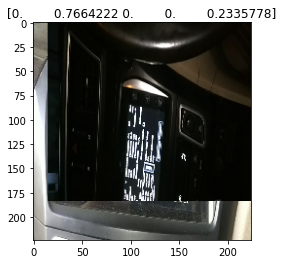